# T-SNE Visualization
This Notebook visulaizes the embeddings of the words and sentences of the th website.

In [4]:
import ast
from db_init import db_get_df, db_save_df
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
import torch
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertModel, BertTokenizer
from tqdm import tqdm
from wordcloud import WordCloud
import gensim
import sqlite3


Zunächst laden wir uns wieder die Daten

In [ ]:
word_embeddings_copy = db_get_df("word_embeddings",["word_embeddings"])

In [ ]:
print(json.loads(word_embeddings_copy["word_embeddings"][0]))
word_embeddings_copy=[json.loads(embedding) for embedding in tqdm(word_embeddings_copy["word_embeddings"])]
# Verwenden Sie 'ast.literal_eval', um Zeichenketten in Listen umzuwandeln
#word_embeddings_copy = word_embeddings_copy.map(ast.literal_eval)

# Wandeln Sie die Listen von Listen in ein Numpy-Array um
word_embeddings = np.array(word_embeddings_copy)

tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
X_embedded = tsne.fit_transform(word_embeddings)
plt.figure(figsize=(10, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], s=5)
plt.title("t-SNE Visualization of Word Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show() 


In [ ]:


# Funktion zur Extraktion von Word Embeddings für die Frage
def get_word_embedding(question, model_name='bert-base-uncased'):
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertModel.from_pretrained(model_name)

    tokens = tokenizer(question, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**tokens)
        question_embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return question_embedding

# Laden der Word Embeddings
word_embeddings_copy = db_get_df("word_embeddings", ["word_embeddings"])
word_embeddings_copy = [json.loads(embedding) for embedding in tqdm(word_embeddings_copy["word_embeddings"])]
word_embeddings = np.array(word_embeddings_copy)

# Extrahieren der Embeddings für die Frage
question_text = "n?"
question_embedding = get_word_embedding(question_text)

# Berechnen der Kosinus-Ähnlichkeit zwischen der Frage und den anderen Word Embeddings
similarities = cosine_similarity(word_embeddings, [question_embedding])

# 'similarities' ist jetzt ein Array mit den Kosinus-Ähnlichkeiten zwischen der Frage und den anderen Word Embeddings.

# Kombinieren Sie die t-SNE-Komponenten mit den Kosinus-Ähnlichkeiten
combined_features = np.column_stack((X_embedded, similarities))

# Visualisierung
plt.figure(figsize=(10, 6))
plt.scatter(combined_features[:, 0], combined_features[:, 1], s=5)
plt.scatter(question_embedding[0], question_embedding[1], color='red', s=50, label='Ihre Frage')
plt.title("t-SNE Visualization of Word Embeddings with Cosine Similarity")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.show()


In [ ]:


# Annahme: X_embedded ist Ihre t-SNE-Visualisierung
# Annahme: word_embeddings ist Ihre Matrix der Word Embeddings
# Annahme: question_text ist Ihre Frage
# Annahme: n_clusters ist die Anzahl der gewünschten Cluster
question_text = "Welche Kompetenzen hat Pr. Gallwitz?" #wann ist der Bewerbungszeitraum  Für das Wintersemester

# Schritt 1: Clustering durchführen
kmeans = KMeans(n_clusters=5, random_state=0)
cluster_labels = kmeans.fit_predict(word_embeddings)

# Schritt 3: Berechnen der Ähnlichkeit zur Frage
question_embedding = get_word_embedding(question_text)  # Verwenden Sie Ihre get_word_embedding Funktion
similarities = cosine_similarity(word_embeddings, [question_embedding])

# Schritt 4: Visualisierung aktualisieren
plt.figure(figsize=(10, 6))
for i in range(5):
    plt.scatter(X_embedded[cluster_labels == i, 0], X_embedded[cluster_labels == i, 1], s=5, label=f'Cluster {i}')

# Farben entsprechend des Clusters für die Frage aktualisieren
question_cluster = np.argmax(similarities)
plt.scatter(X_embedded[question_cluster, 0], X_embedded[question_cluster, 1], s=50, color='red', label='Ihre Frage')

plt.title("t-SNE Visualization of Word Embeddings with Clusters")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.show()


In [ ]:
kmeans = KMeans(n_clusters=5)  # Specify the number of clusters you want
cluster_labels = kmeans.fit_predict(word_embeddings)


In [ ]:
plt.figure(figsize=(10, 6))
for i in range(len(np.unique(cluster_labels))):
    plt.scatter(X_embedded[cluster_labels == i, 0], X_embedded[cluster_labels == i, 1], s=5, label=f'Cluster {i}')

plt.title("t-SNE Visualization of Word Embeddings with Clusters")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.show()

In [ ]:
# Call the db_get_df function to get the DataFrame
df = db_get_df()

# Print the first 2 rows of the DataFrame
first_2_rows = df.head(2)
print(first_2_rows)


In [ ]:
# Filter the indices of data points in Cluster 0
cluster0_indices = np.where(cluster_labels == 0)

# Get the corresponding rows from the DataFrame 'df'
cluster0_data_rows = df.iloc[cluster0_indices]

# Print the 'text' column for the data points in Cluster 0
for text in cluster0_data_rows['text']:
    print(text)


In [ ]:


# Annahme: Ihr DataFrame 'df' enthält eine Spalte 'text' mit den Textdaten.

# Anzahl der Cluster (angenommen, es sind 5 Cluster)
num_clusters = 5

for cluster_id in range(num_clusters):
    # Filtern Sie die Zeilen für den aktuellen Cluster
    cluster_data_rows = df

    # Laden des spaCy-Modells für die Textverarbeitung
    nlp = spacy.load("de_core_news_sm")

    # Benutzerdefinierte Stoppwortliste
    stopwords = {'www', 'th-nuernberg', 'nürnberg', 'nuernberg', 'th', 'technische', 'hochschule', 'ohm', 'de', 'punkt', 'simon'}

    # Tokenisieren und Lemmatisieren der Texte, Entfernen der Stoppwörter und Konvertieren in Strings
    processed_texts = []
    for text in cluster_data_rows['text']:
        doc = nlp(text)
        processed_tokens = []
        for token in doc:
            if token.text.lower() not in stopwords and token.pos_ in {'NOUN', 'PROPN'}:
                processed_tokens.append(token.text)
        processed_texts.append(' '.join(processed_tokens))

    # Erstellen eines Wörterbuchs und einer Textkorpus für das LDA-Modell
    text_tokens = [text.split() for text in processed_texts]
    dictionary = gensim.corpora.Dictionary(text_tokens)
    corpus = [dictionary.doc2bow(tokens) for tokens in text_tokens]

    # Anwendung des LDA-Modells
    lda_model = gensim.models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

    # Anzeigen der Hauptthemen für den aktuellen Cluster
    print(f"Cluster {cluster_id} Topics:")
    for topic_id, topic in lda_model.print_topics():
        print(f"Topic {topic_id}: {topic}")
    print("\n")


In [ ]:


all_text = ' '.join(processed_texts)  # 'processed_texts' ist die Liste der bereinigten Texte

# Erstellen der Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Anzeigen der Word Cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud")
plt.show()

In [ ]:


# Erstellen einer Liste von Stoppwörtern, einschließlich der URL und der benutzerdefinierten Wörter
stopwords = set(['www', 'th-nuernberg', 'nürnberg', 'nuernberg', 'th', 'technische', 'hochschule', 'ohm', 'de', 'punkt', 'simon','https','http','nuremberg','telefon','email','fax','Prof Dr','studium'])
stopwords = set(word.lower() for word in stopwords)  # In Kleinbuchstaben umwandeln

# Anzahl der Cluster (angenommen, es sind 5 Cluster)
num_clusters = 5

for cluster_id in range(num_clusters):
    if cluster_id == 1:
        continue
    # Filter the indices of data points in the current cluster
    cluster_indices = np.where(cluster_labels == cluster_id)

    # Get the corresponding rows from the DataFrame 'df'
    cluster_data_rows = df.iloc[cluster_indices]

    # Extract and preprocess text data
    texts = cluster_data_rows['text']
    nlp = spacy.load("de_core_news_sm")
    processed_texts = [' '.join([token.text for token in nlp(text) if not token.is_stop and token.text.lower() not in stopwords]) for text in texts]

    # Create a Word Cloud for the current cluster
    all_text = ' '.join(processed_texts)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

    # Display the Word Cloud for the current cluster
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for Cluster {cluster_id}")
    plt.show()


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Flatten the list of embeddings to a single array
flattened_embeddings = [embedding for sublist in embeddings for embedding in sublist]
print(flattened_embeddings)
# Convert the list of embeddings to a NumPy array
embeddings_array = np.array(flattened_embeddings)

# Reduce the dimensions using t-SNE to 2D
tsne = TSNE(n_components=2, random_state=42)

embeddings_2d = []
batch_size = 1000  # Adjust the batch size as needed

# Apply t-SNE in batches to track progress
for i in tqdm(range(0, len(embeddings_array), batch_size)):
    embeddings_batch = embeddings_array[i:i + batch_size]
    embeddings_2d_batch = tsne.fit_transform(embeddings_batch)
    embeddings_2d.extend(embeddings_2d_batch)

# Plot the 2D embeddings
embeddings_2d = np.array(embeddings_2d)

plt.figure(figsize=(10, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5)
plt.title('t-SNE Visualization of Sentence Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm

# Assuming 'embeddings' contains the generated sentence embeddings
flat_embeddings = np.array([emb for sublist in embeddings for emb in sublist])

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = []

# Apply t-SNE for dimensionality reduction with progress bar
with tqdm(total=len(flat_embeddings)) as pbar:
    for i in range(0, len(flat_embeddings), 100):  # Process in batches for efficiency
        embeddings_2d_batch = tsne.fit_transform(flat_embeddings[i:i + 100])
        embeddings_2d.append(embeddings_2d_batch)
        pbar.update(100)

# Flatten the results
embeddings_2d = np.vstack(embeddings_2d)

# Plot the 2D t-SNE visualization
plt.figure(figsize=(10, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], marker='.')
plt.title('t-SNE Visualization of Sentence Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()


In [ ]:
#TODO
question_text = "Welche Kompetenzen hat Pr. Gallwitz?" #embeddings machen
embeddings # schauen welche 5 am nächsten sind

In [ ]:
embeddings_df = db_get_df("embeddings1")


In [ ]:

filenames = embeddings_df.head(5)
print(filenames.to_markdown())


In [ ]:
from dotenv import load_dotenv
import os

load_dotenv()
database_path = os.getenv("DATABASE_PATH")
def db_delete_table(tablename):
    with sqlite3.connect(database_path) as con:
        cursor = con.cursor()
        # Execute an SQL query to drop/delete the specified table
        cursor.execute(f"DROP TABLE IF EXISTS {tablename};")
        con.commit()

# Delete the table named 'all-MiniLM-L6-v2' from the SQLite database
db_delete_table("embeddings1")

Visualisation of 'sentence-transformers/all-MiniLM-L6-v2' model embeddings: 

In [ ]:
embeddings_df = db_get_df("embeddings1")

tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings_df)

# Plot the t-SNE embeddings
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], alpha=0.5)
plt.title('t-SNE Visualization of Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

K-means clustering

In [ ]:
from sklearn.cluster import KMeans
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings_df)

# Apply K-means clustering
num_clusters = 5  # Define the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings_df)

# Add cluster labels to the DataFrame
embeddings_df['Cluster'] = cluster_labels

# Convert feature names to string data type
embeddings_df.columns = embeddings_df.columns.astype(str)

# Plot the t-SNE visualization of embeddings with clusters
plt.figure(figsize=(10, 8))
for cluster in range(num_clusters):
    cluster_points = embeddings_tsne[cluster_labels == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], alpha=0.5, label=f'Cluster {cluster}')

plt.title('t-SNE Visualization of Embeddings with Clusters')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

Visualisation of 'paraphrase-MiniLM-L6-v2' model embeddings: 

In [ ]:
embeddings_df = db_get_df("embeddings2")

tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings_df)

# Plot the t-SNE embeddings
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], alpha=0.5)
plt.title('t-SNE Visualization of Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [ ]:
from sklearn.cluster import KMeans
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings_df)

# Apply K-means clustering
num_clusters = 5  # Define the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings_df)

# Add cluster labels to the DataFrame
embeddings_df['Cluster'] = cluster_labels

# Convert feature names to string data type
embeddings_df.columns = embeddings_df.columns.astype(str)

# Plot the t-SNE visualization of embeddings with clusters
plt.figure(figsize=(10, 8))
for cluster in range(num_clusters):
    cluster_points = embeddings_tsne[cluster_labels == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], alpha=0.5, label=f'Cluster {cluster}')

plt.title('t-SNE Visualization of Embeddings with Clusters')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

Visualisation of 'sentence-transformers/msmarco-distilbert-base-tas-b' model embeddings: 

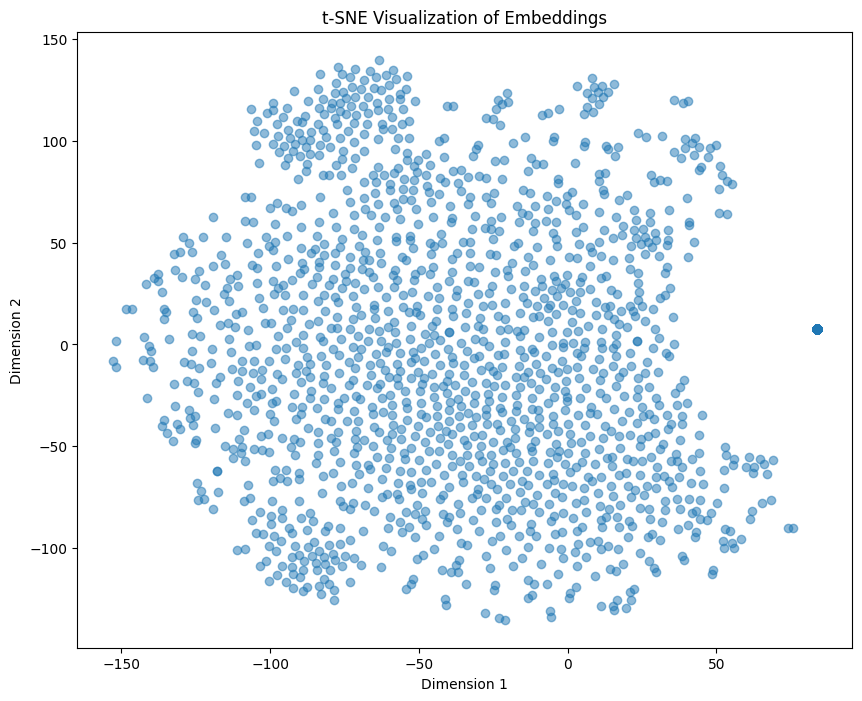

In [6]:
embeddings_df = db_get_df("embeddings2")

tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings_df)

# Plot the t-SNE embeddings
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], alpha=0.5)
plt.title('t-SNE Visualization of Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

Visualisation of 'sentence-transformers/multi-qa-MiniLM-L6-cos-v1' model embeddings: 

In [ ]:
embeddings_df = db_get_df("embeddings4")

tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings_df)

# Plot the t-SNE embeddings
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], alpha=0.5)
plt.title('t-SNE Visualization of Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [ ]:
similarities_df = db_get_df("similarities1")
top_n = 5
most_similar_indices = similarities_df.nlargest(top_n, 'similarity')['index']
most_similar_articles = df.loc[most_similar_indices]